In [ ]:

# Setup (Colab/local)
import sys, os, subprocess
from pathlib import Path

# Instalar requirements si estamos en Colab
def install_requirements(req_path: Path):
    if req_path.exists():
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r", str(req_path)], check=True)
    else:
        print(f"requirements.txt no encontrado en {req_path}, ajusta ROOT manualmente")

if 'google.colab' in sys.modules:
    candidates = [
        Path('/content/tp_decision_transformer/requirements.txt'),
        Path('/content/drive/MyDrive/tp_decision_transformer/requirements.txt'),
    ]
    for cand in candidates:
        if cand.exists():
            install_requirements(cand)
            break

# Detectar ROOT del repo
CANDIDATES = [
    Path.cwd(),
    Path('/content/tp_decision_transformer'),
    Path('/content/drive/MyDrive/tp_decision_transformer'),
]
for cand in CANDIDATES:
    if (cand / 'config_dataset.py').exists():
        ROOT = cand
        break
else:
    raise RuntimeError('No se encontró config_dataset.py; ajusta ROOT')

os.chdir(ROOT)
sys.path.append(str(ROOT))
print('ROOT:', ROOT)



# 02 - Training Decision Transformer
Notebook de entrenamiento siguiendo la guía (opción 1).


In [1]:

%matplotlib inline
import sys, pathlib
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Ajustar path al root
try:
    ROOT
except NameError:
    ROOT = pathlib.Path.cwd()
    if (ROOT / 'config_dataset.py').exists():
        sys.path.append(str(ROOT))
    elif (ROOT.parent / 'config_dataset.py').exists():
        ROOT = ROOT.parent
        sys.path.append(str(ROOT))

from config_dataset import NUM_ITEMS
from src.data.load_data import load_training_data
from src.data.preprocessing import create_dt_dataset, validate_preprocessing
from src.data.dataset import RecommendationDataset
from src.models.decision_transformer import DecisionTransformer
from src.training.trainer import train_decision_transformer

print(f"NUM_ITEMS: {NUM_ITEMS}")
print(f"GPU disponible: {torch.cuda.is_available()}")


NUM_ITEMS: 472
GPU disponible: False



## Cargar datos procesados
Usa `data/processed/trajectories_train.pkl` si está disponible, sino procesa desde cero.


In [2]:

import pickle
from pathlib import Path

processed_path = ROOT / 'data/processed/trajectories_train.pkl'

if processed_path.exists():
    with processed_path.open('rb') as f:
        trajectories = pickle.load(f)
    print(f"Cargadas trayectorias desde {processed_path} -> {len(trajectories)}")
else:
    df_train = load_training_data()
    trajectories = create_dt_dataset(df_train)
    validate_preprocessing(trajectories)
    processed_path.parent.mkdir(parents=True, exist_ok=True)
    with processed_path.open('wb') as f:
        pickle.dump(trajectories, f)
    print(f"Generadas y guardadas trayectorias -> {len(trajectories)}")


Cargadas trayectorias desde /home/manu/Documentos/diplo/tp_decision_transformer/data/processed/trajectories_train.pkl -> 16000



## Train/Val split y DataLoaders


In [3]:

context_length = 20
batch_size = 64  # subir si la GPU lo permite (reduce si falta memoria)
val_frac = 0.1

full_dataset = RecommendationDataset(trajectories, context_length=context_length)
val_size = int(len(full_dataset) * val_frac)
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}")
print(f"Batch size: {batch_size}")


Train size: 14400, Val size: 1600
Batch size: 64



## Instanciar modelo y optimizador


In [4]:

hidden_dim = 256  # capacidad alta, requiere GPU
n_layers = 4
n_heads = 8
learning_rate = 2e-4  # LR más conservador para entrenamiento largo
num_epochs = 100  # entrenamiento prolongado  # ajusta según recursos

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



## Entrenamiento


In [5]:

model, history = train_decision_transformer(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    val_loader=val_loader,
)


Epoch 1/100 - train_loss=6.1586
  val_loss=6.1576
Epoch 2/100 - train_loss=6.1576
  val_loss=6.1572
Epoch 3/100 - train_loss=6.1574
  val_loss=6.1572
Epoch 4/100 - train_loss=6.1574
  val_loss=6.1573
Epoch 5/100 - train_loss=6.1572
  val_loss=6.1572
Epoch 6/100 - train_loss=6.1572
  val_loss=6.1573
Epoch 7/100 - train_loss=6.1572
  val_loss=6.1574
Epoch 8/100 - train_loss=6.1571
  val_loss=6.1573
Epoch 9/100 - train_loss=6.1571
  val_loss=6.1572
Epoch 10/100 - train_loss=6.1571
  val_loss=6.1575
Epoch 11/100 - train_loss=6.1571
  val_loss=6.1573
Epoch 12/100 - train_loss=6.1570
  val_loss=6.1573
Epoch 13/100 - train_loss=6.1570
  val_loss=6.1572
Epoch 14/100 - train_loss=6.1569
  val_loss=6.1573
Epoch 15/100 - train_loss=6.1569
  val_loss=6.1572
Epoch 16/100 - train_loss=6.1569
  val_loss=6.1572
Epoch 17/100 - train_loss=6.1570
  val_loss=6.1571
Epoch 18/100 - train_loss=6.1569
  val_loss=6.1571
Epoch 19/100 - train_loss=6.1568
  val_loss=6.1572
Epoch 20/100 - train_loss=6.1569
  val_l


## Curva de loss


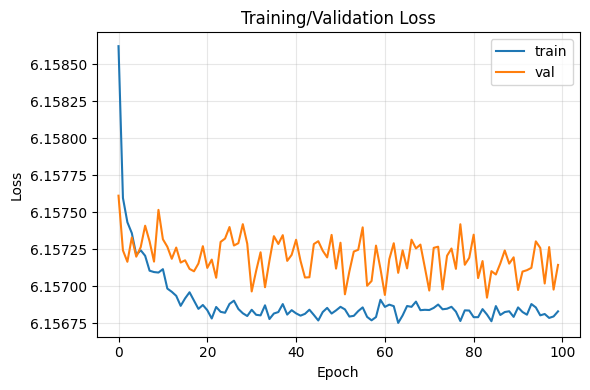

In [6]:

plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train')
if history['val_loss']:
    plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Guardar checkpoint


In [7]:

ckpt_path = ROOT / 'results/checkpoints/dt_checkpoint.pt'
ckpt_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), ckpt_path)
print(f"Checkpoint guardado en {ckpt_path}")


Checkpoint guardado en /home/manu/Documentos/diplo/tp_decision_transformer/results/checkpoints/dt_checkpoint.pt
